# Utilities

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
import optuna
import os
import pywt


optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
def read_files(filenames: list):
    """
    Read a list of files and return a single dataframe
    
    Parameters:
    -----------
    filenames : list
        List of filenames to read
    
    Returns:
    --------
    pd.DataFrame
    """
    return pd.concat([pd.read_csv(f'./data/{filename}') for filename in filenames])


def read_all_files():
    """
    Read all files in the data directory and return a single dataframe
    
    Returns:
    --------
    pd.DataFrame
    """

    dir = os.listdir('./data/')

    filenames = [filename for filename in dir if filename.endswith('.csv')]
    
    return read_files(filenames)

def categorize_port(port):
    if port in [80, 443, 444, 8080, 8443]:  # Common web ports
        return 'web'
    elif port in [22, 23, 21]:  # SSH, Telnet, FTP
        return 'remote_access'
    elif port in [53]:  # DNS
        return 'dns'
    elif port in range(10, 1024):  # Well-known ports
        return 'well_known'
    elif port in range(1024, 49151):  # Registered ports
        return 'registered'
    elif port >= 49152:  # Dynamic/private ports
        return 'dynamic'
    else:
        return 'unknown'  # Other/unknown ports

In [3]:
class Data:
    def __init__(self, df, prepare_index = False):
        if prepare_index:
            df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed')
            df = df.set_index('timestamp')
            df = df.sort_index()
        
        self.df = df

    def assign(self, **kwargs):
        return Data(self.df.assign(**kwargs))
    
    def benign(self):
        return self.with_label('Benign')

    def with_label(self, label):
        return Data(self.df[self.df['label'] == label])
    
    def with_date(self, date):
        return Data(self.df.loc[date])
    
    def internal_dst(self):
        return Data(self.df[self.df['dst_ip'].str.contains('192.168')])
    
    def get_dummies(self, columns, dtype = int, drop_first = False):
        return Data(pd.get_dummies(self.df, columns = columns, dtype=dtype, drop_first=drop_first))
    
    def resample(self, resampler):
        return Data(resampler.resample(self))
    
    def X_y(self, y_column):
        return self.df.drop(columns = y_column), self.df[y_column]
    
    def show(self):
        display(self.df)

class Resampler:
    def __init__(self, agg, interval = '1s', interpolate = 'zero'):
        self.agg = agg
        self.interval = interval
        self.interpolate = interpolate
    
    def resample(self, data):
        return data.df.resample(self.interval).agg(self.agg).interpolate(self.interpolate)
    


# Load the data

In [111]:
df = read_all_files()

# Intrusion Detection

## Preprocess the data

In [154]:
data = Data(df, prepare_index=True)

In [155]:
TRAIN_DAY = '2017-07-03'

internal = data.internal_dst().assign(
    dst_host_port = lambda x: x['dst_ip'] + ":" + x['dst_port'].astype(str),
    dst_port_category=lambda x: x['dst_port'].apply(categorize_port),
    src_port_category=lambda x: x['src_port'].apply(categorize_port)
).get_dummies(['dst_port_category', 'src_port_category'])

internal.show()

,flow_id,src_ip,src_port,dst_ip,dst_port,protocol,duration,packets_count,fwd_packets_count,bwd_packets_count,...,dst_port_category_unknown,dst_port_category_web,dst_port_category_well_known,src_port_category_dns,src_port_category_dynamic,src_port_category_registered,src_port_category_remote_access,src_port_category_unknown,src_port_category_web,src_port_category_well_known
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-07-03 07:55:58.598308,8.254.250.126_80_192.168.10.5_49188_TCP_2017-0...,8.254.250.126,80,192.168.10.5,49188,TCP,0.000010,8,8,0,...,0,0,0,0,0,0,0,0,1,0
2017-07-03 07:56:22.331018,8.253.185.121_80_192.168.10.14_49486_TCP_2017-...,8.253.185.121,80,192.168.10.14,49486,TCP,0.000010,9,9,0,...,0,0,0,0,0,0,0,0,1,0
2017-07-03 07:56:37.897192,192.168.10.9_137_192.168.10.3_137_UDP_2017-07-...,192.168.10.9,137,192.168.10.3,137,UDP,83.068408,80,38,42,...,0,0,1,0,0,0,0,0,0,1
2017-07-03 07:56:37.908429,192.168.10.9_63683_192.168.10.3_53_UDP_2017-07...,192.168.10.9,63683,192.168.10.3,53,UDP,0.000292,4,2,2,...,0,0,0,0,1,0,0,0,0,0
2017-07-03 07:56:37.908639,192.168.10.9_63276_192.168.10.3_53_UDP_2017-07...,192.168.10.9,63276,192.168.10.3,53,UDP,0.000293,4,2,2,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-07-07 16:02:38.913542,192.168.10.8_123_192.168.10.3_123_UDP_2017-07-...,192.168.10.8,123,192.168.10.3,123,UDP,0.000125,4,2,2,...,0,0,1,0,0,0,0,0,0,1
2017-07-07 16:02:39.565876,192.168.10.50_22_192.168.10.17_37758_TCP_2017-...,192.168.10.50,22,192.168.10.17,37758,TCP,0.000085,3,0,3,...,0,0,0,0,0,0,1,0,0,0
2017-07-07 16:02:39.567285,192.168.10.17_37759_192.168.10.50_22_TCP_2017-...,192.168.10.17,37759,192.168.10.50,22,TCP,1.238502,85,42,43,...,0,0,0,0,0,1,0,0,0,0


In [156]:
resampler = Resampler({
    "payload_bytes_std": lambda x: 1 / (np.mean(x) ** 2 + 0.00001),
    "dst_port_category_web": "sum",
    "syn_flag_counts": "sum",
    "dst_host_port": "nunique",
    "label": lambda x: 1 if x.eq("Benign").all() else -1
}, '1s')

TRAIN_DAY = '2017-07-05'
TEST_DAY = '2017-07-07'

monday = internal.with_date(TRAIN_DAY).with_label('Benign').resample(resampler)
friday = internal.with_date(TEST_DAY).resample(resampler)

monday.show()
friday.show()

,payload_bytes_std,dst_port_category_web,syn_flag_counts,dst_host_port,label
timestamp,,,,,
2017-07-05 07:42:42,0.000015,0,0,6,1
2017-07-05 07:42:43,0.000031,0,13,4,1
2017-07-05 07:42:44,0.001850,0,0,1,1
2017-07-05 07:42:45,0.001850,0,0,0,1
2017-07-05 07:42:46,0.001850,0,0,0,1
...,...,...,...,...,...
2017-07-05 16:10:10,100000.000000,0,0,0,1
2017-07-05 16:10:11,100000.000000,0,0,0,1
2017-07-05 16:10:12,100000.000000,0,0,0,1


,payload_bytes_std,dst_port_category_web,syn_flag_counts,dst_host_port,label
timestamp,,,,,
2017-07-07 07:59:50,0.000031,0,0,2,1
2017-07-07 07:59:51,0.000031,0,0,0,1
2017-07-07 07:59:52,0.000031,0,0,0,1
2017-07-07 07:59:53,0.000031,0,0,0,1
2017-07-07 07:59:54,0.000031,0,0,0,1
...,...,...,...,...,...
2017-07-07 16:02:37,100000.000000,0,0,1,1
2017-07-07 16:02:38,0.000135,0,8,4,1
2017-07-07 16:02:39,0.000070,0,4,2,1


<Axes: >

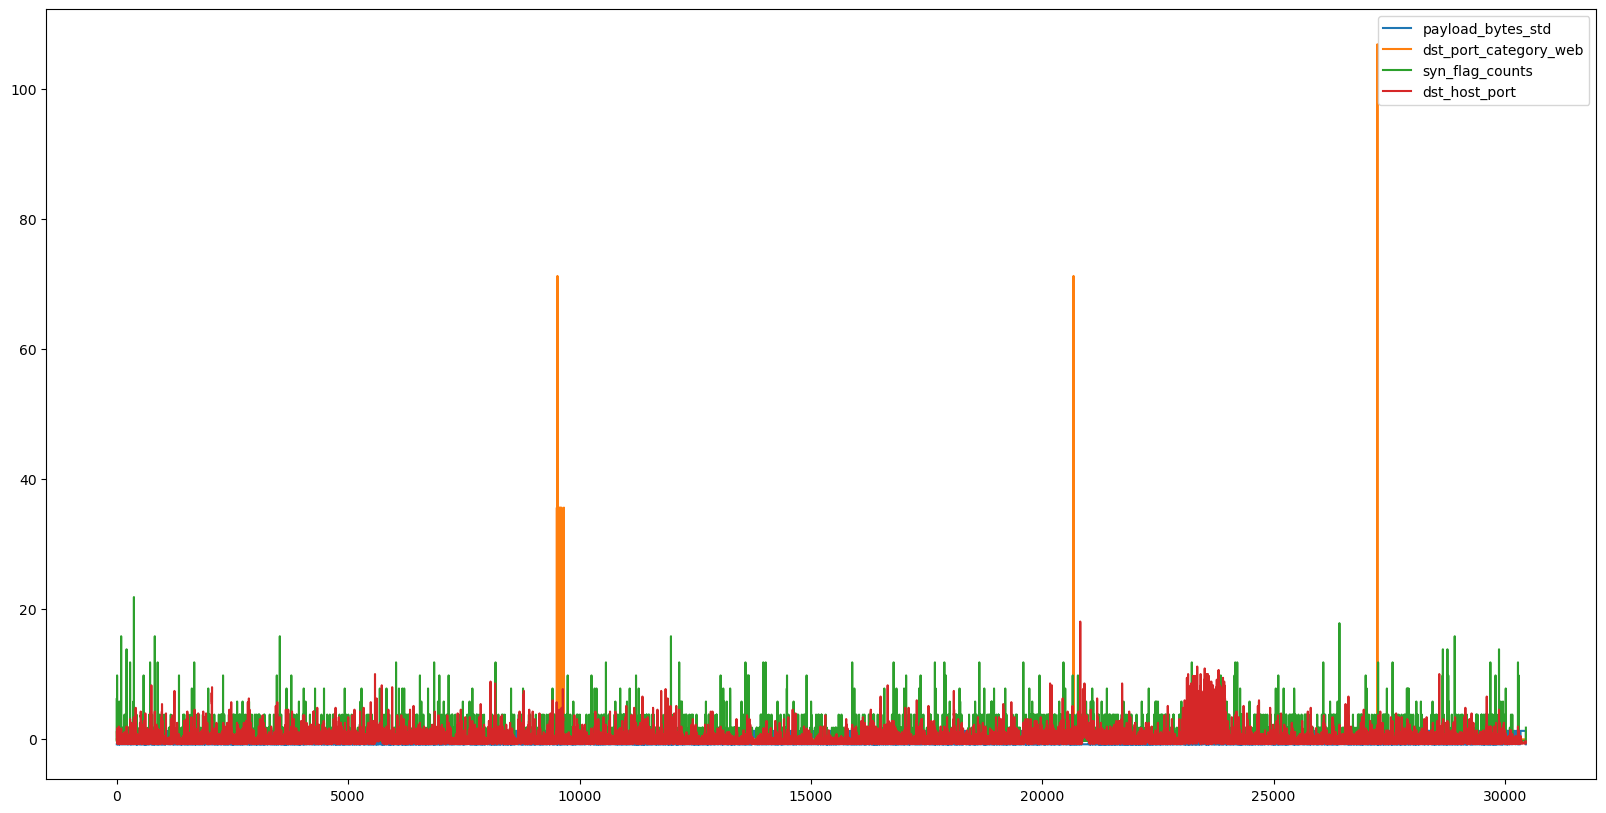

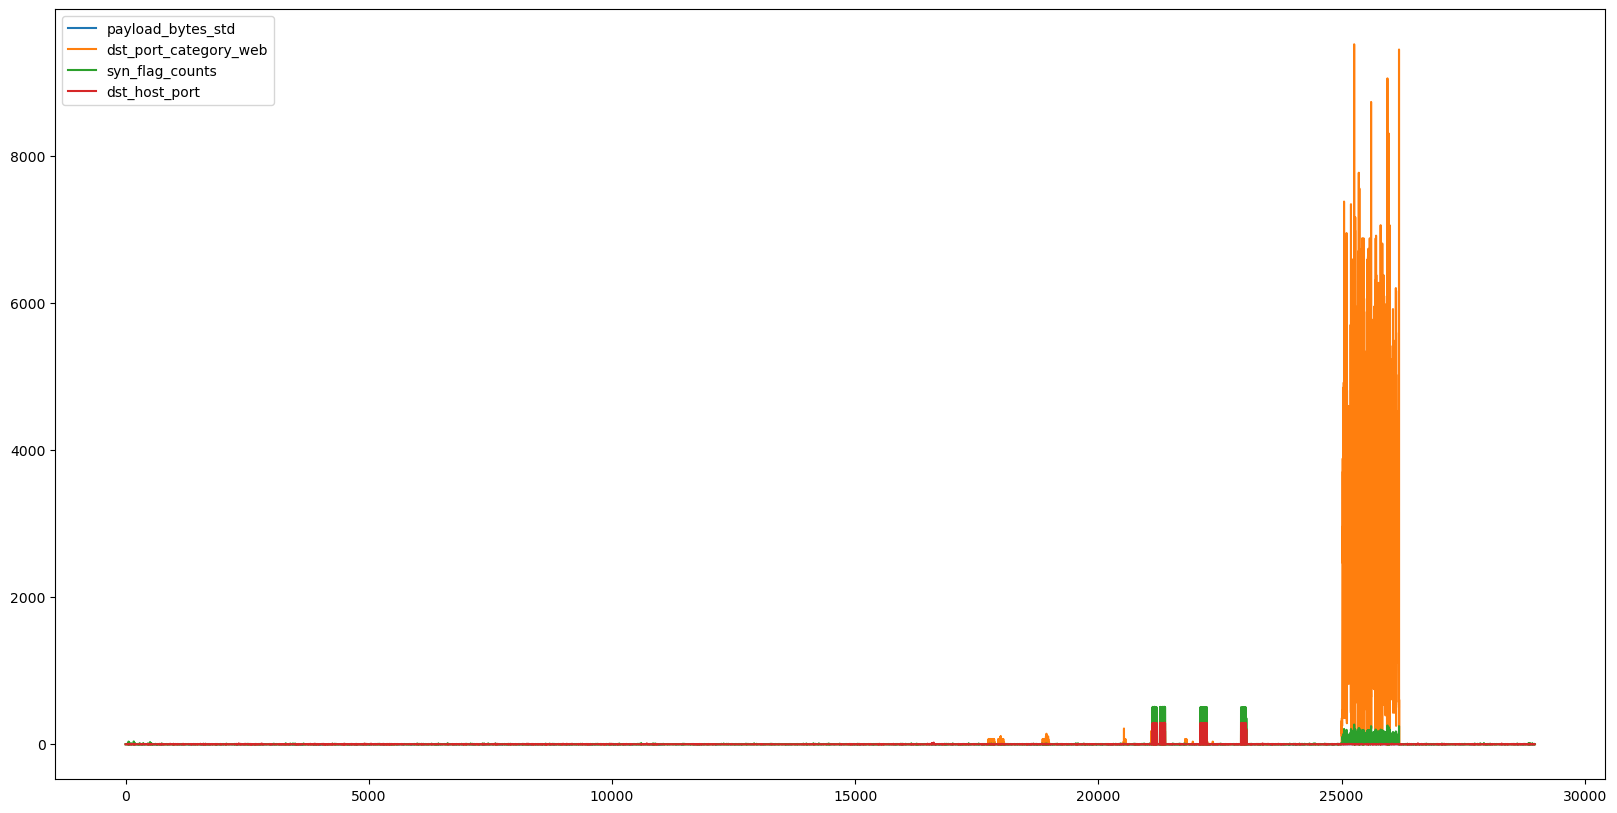

In [157]:
X_monday, y_monday = monday.X_y('label')
X_friday, y_friday = friday.X_y('label')


scaler = StandardScaler()
X_monday = pd.DataFrame(scaler.fit_transform(X_monday), columns=X_monday.columns)
X_friday = pd.DataFrame(scaler.transform(X_friday), columns=X_friday.columns)

X_monday.plot(figsize=(20, 10))
X_friday.plot(figsize=(20, 10))

  0%|          | 0/100 [00:00<?, ?it/s]

Best Parameters: {'contamination': 0.0073983449075558155}
best score: 0.7992047713717694
              precision    recall  f1-score   support

     Anomaly       0.88      0.73      0.80      1641
      Normal       0.98      0.99      0.99     27331

    accuracy                           0.98     28972
   macro avg       0.93      0.86      0.89     28972
weighted avg       0.98      0.98      0.98     28972



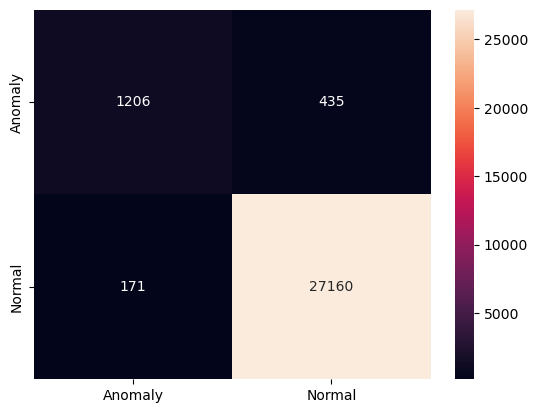

In [ ]:

y_true = y_friday.reset_index(drop=True)

def objective(trial):
    c = trial.suggest_float("contamination", 0.001, 0.2)

    clf = IsolationForest(contamination=c, bootstrap=True, random_state=3123)
    clf.fit(X_monday)

    y_pred = clf.predict(X_friday)

    return f1_score(y_true, y_pred, average="binary", pos_label=-1)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, n_jobs=8, show_progress_bar=True)

print("Best Parameters:", study.best_params)
print("Best score:", study.best_value)

clf = IsolationForest(contamination=study.best_params['contamination'], bootstrap=True, random_state=3123)

clf.fit(X_monday)

y_pred = clf.predict(X_friday)

sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', xticklabels=['Anomaly', 'Normal'], yticklabels=['Anomaly', 'Normal'])
print(classification_report(y_true, y_pred, target_names=['Anomaly', 'Normal']))

## Apply SWT


Choosign wavelet: https://www.mathworks.com/help/wavelet/gs/choose-a-wavelet.html

In [192]:
def swt_transform(X, wavelet='haar', level=2):
    if X.shape[0] % 2 != 0:
        X = X.iloc[:-1]
    
    coefs = pywt.swtn(X, wavelet, level=level, trim_approx=True, norm=True)[level - 1]

    return pd.DataFrame(coefs['ad'], columns=X.columns)

def plot_coefs(coefs):
    plt.figure(figsize=(20, 10))
    plt.plot(coefs)
    plt.legend(coefs.columns)
    plt.show() 

X_monday_swt = swt_transform(X_monday, 'db2')
X_friday_swt = swt_transform(X_friday, 'db2')

<Axes: >

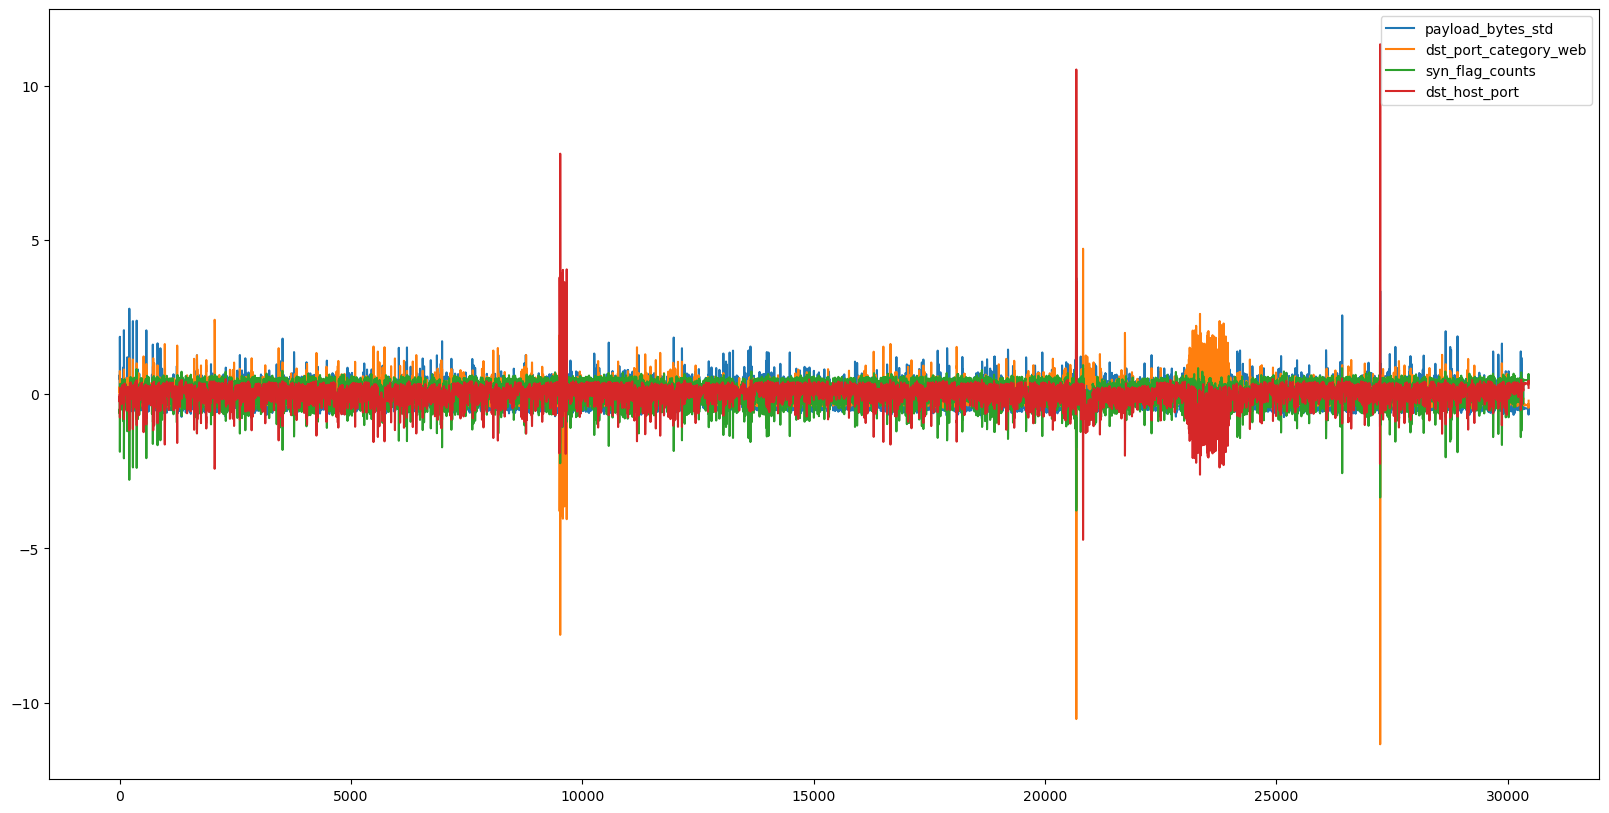

In [193]:
X_monday_swt.plot(figsize=(20, 10))

<Axes: >

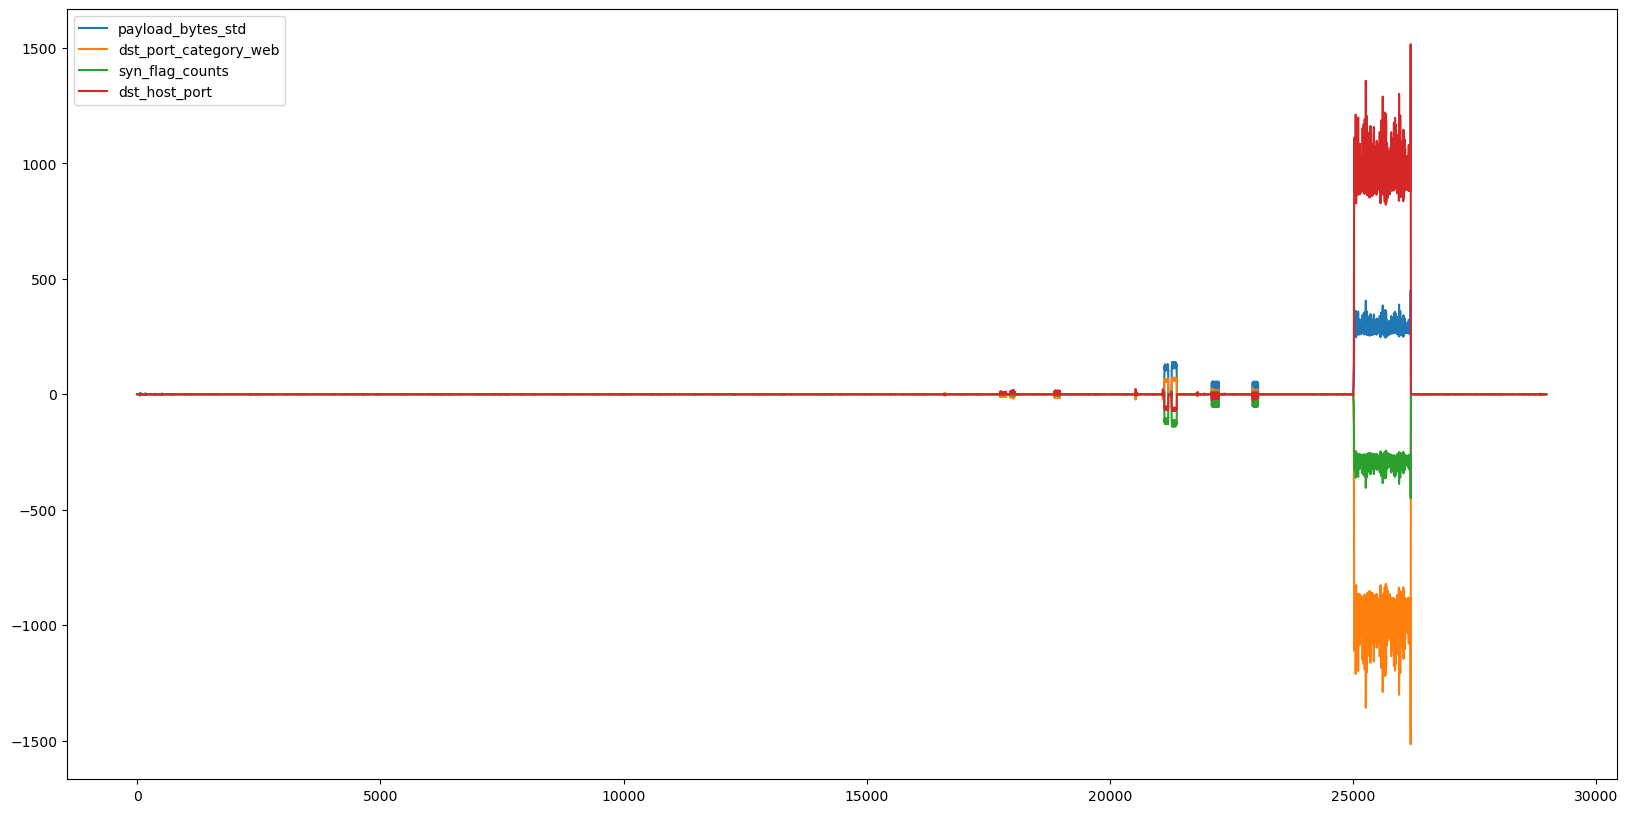

In [194]:
X_friday_swt.plot(figsize=(20, 10))

## Isolation forest

  0%|          | 0/100 [00:00<?, ?it/s]

Best Parameters: {'contamination': 0.0010050369599520282}
best score: 0.8413793103448276
              precision    recall  f1-score   support

     Anomaly       0.80      0.89      0.84      1641
      Normal       0.99      0.99      0.99     27331

    accuracy                           0.98     28972
   macro avg       0.89      0.94      0.92     28972
weighted avg       0.98      0.98      0.98     28972



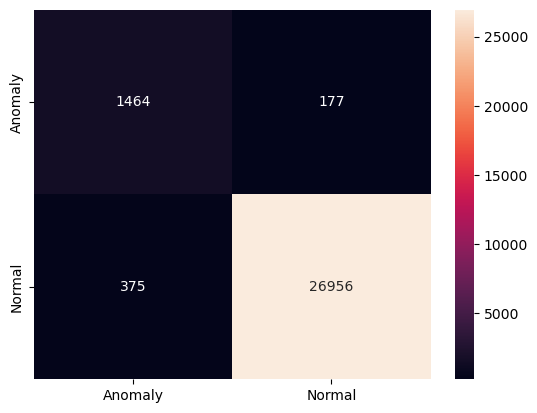

In [195]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
import optuna

y_true = y_friday.reset_index(drop=True)

def objective(trial):
    c = trial.suggest_float("contamination", 0.001, 0.2)  # Contamination

    clf = IsolationForest(contamination=c, bootstrap=True, random_state=3123)
    clf.fit(X_monday_swt)

    y_pred = clf.predict(X_friday_swt)

    return f1_score(y_true, y_pred, average="binary", pos_label=-1)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, n_jobs=8, show_progress_bar=True)

print("Best Parameters:", study.best_params)

print("best score:", study.best_value)

clf = IsolationForest(contamination=study.best_params['contamination'], bootstrap=True, random_state=3123)

clf.fit(X_monday_swt)

y_pred = clf.predict(X_friday_swt)

sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', xticklabels=['Anomaly', 'Normal'], yticklabels=['Anomaly', 'Normal'])
print(classification_report(y_true, y_pred, target_names=['Anomaly', 'Normal']))

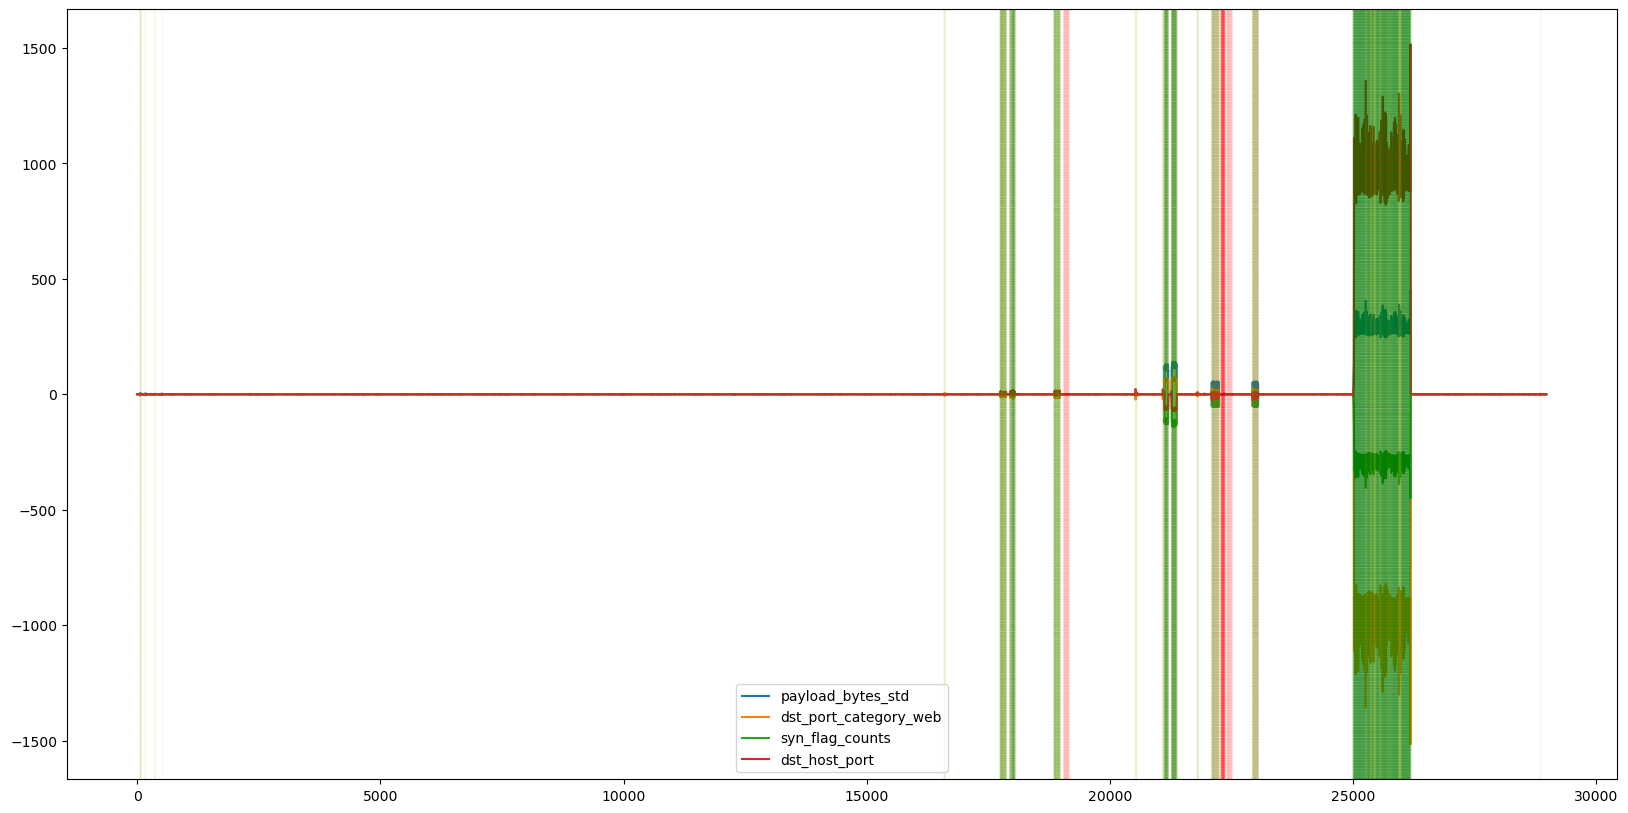

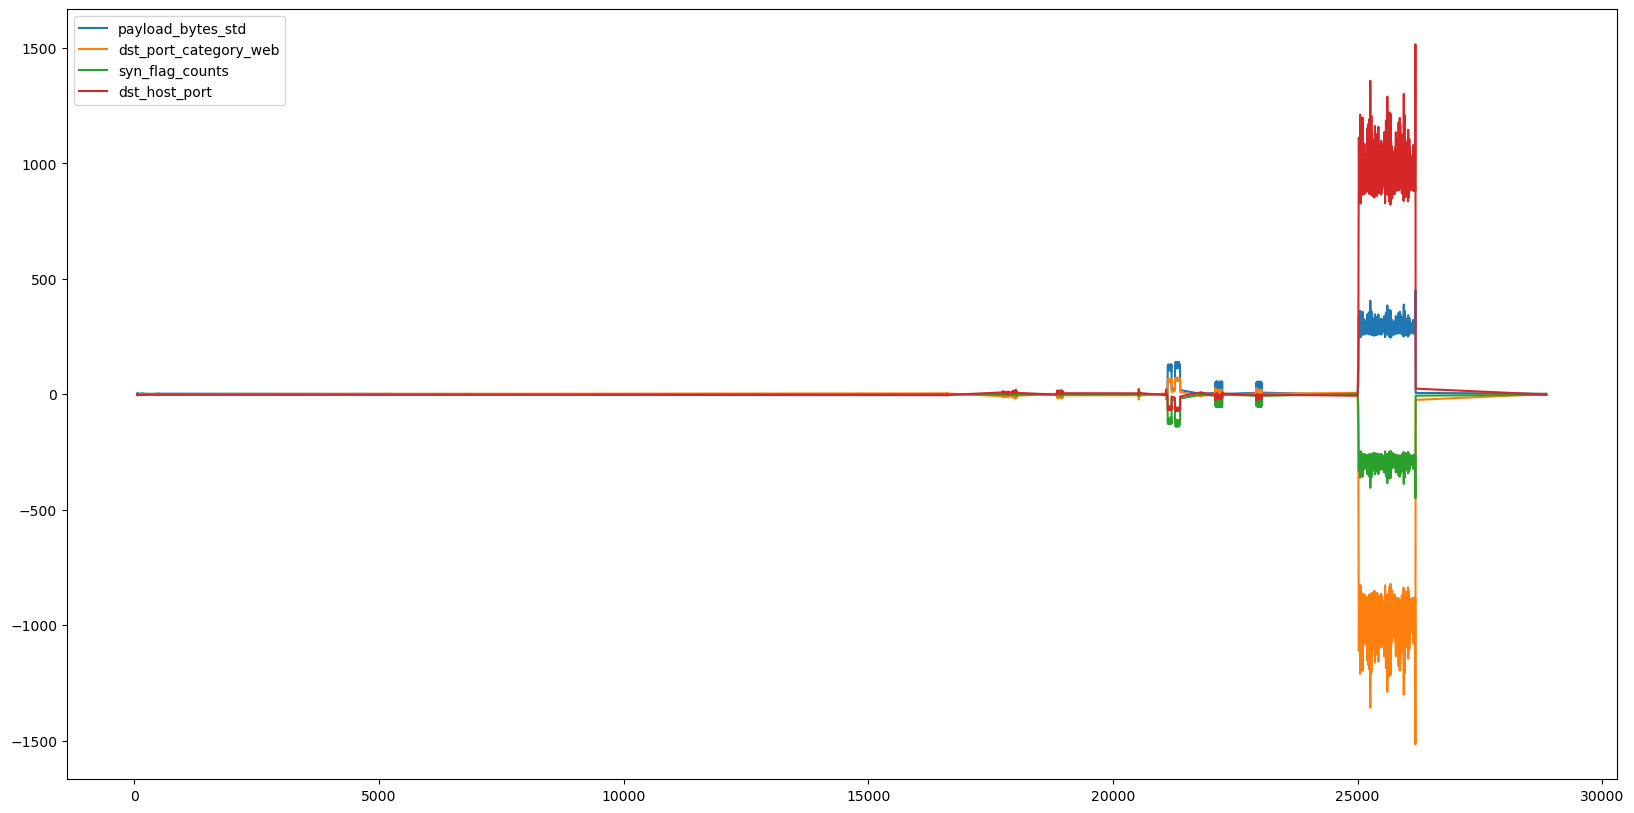

In [196]:
# plot outliers on test data

plt.figure(figsize=(20, 10))
plt.plot(X_friday_swt)

for i in X_friday_swt[y_pred == -1].index:
    if i not in y_true[y_true == -1].index:
        plt.axvline(i, 0, 1, color='y', linestyle='dashed', linewidth=0.1, alpha=0.5)
    else:
        plt.axvline(i, 0, 1, color='g', linestyle='dashed', linewidth=0.1, alpha=0.5)

for i in y_true[y_true == -1].index:
    if i not in X_friday_swt[y_pred == -1].index:
        plt.axvline(i, 0, 1, color='r', linestyle='dashed', linewidth=0.1, alpha=0.5)

plt.legend(X_friday_swt.columns)
plt.show()

plt.figure(figsize=(20, 10))
plt.plot(X_friday_swt[y_pred == -1])
plt.legend(X_friday_swt.columns)
plt.show()